# Publications, datasets, and software by a particular researcher

This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to fetch all DataCite references of the DataCite publications, datasets and software authored by a particular researcher, using his/her ORCID ID.

In [29]:
# Prepare the R graphql client.

#install.packages("httr")
#install.packages("ghql")
#install.packages("jsonlite")
#install.packages("IRdisplay")
#install.packages("dplyr")
#install.packages("igraph")
#install.packages("RColorBrewer")

library("httr")
library("ghql")
library("jsonlite")
library("IRdisplay")
library("dplyr")
library("igraph")
library("RColorBrewer")

cli <- GraphqlClient$new(
  url = "https://api.datacite.org/graphql"
)
qry <- Query$new()

In [30]:
# Generate the GraphQL query: find the researcher by ORCID ID, then fetch the first 50 publications, datasets and software with DataCite DOIs linked to that ORCID account.

query <- ' {
  person(id: "https://orcid.org/0000-0003-1419-2405") {
    id
    type
    name
    publications(first: 50) {
      totalCount
      nodes {
        id
        type
        relatedIdentifiers {
          relatedIdentifier
        }
      }
    }
    datasets(first: 50) {
      totalCount
      nodes {
        id
        type
        relatedIdentifiers {
          relatedIdentifier
        }
      }
    }
    softwares(first: 50) {
      totalCount
      nodes {
        id
        type
        relatedIdentifiers {
          relatedIdentifier
        }
      }
    }
  }
}'

In [31]:
# Run the query and parse the JSON response

qry$query('getdata', query)
data <- fromJSON(cli$exec(qry$queries$getdata))

In [32]:
# Get the name of the researcher with ORCID ID https://orcid.org/0000-0003-1419-2405

display_markdown(data$data$person$name)

Martin Fenner

In [33]:
# Get the number of publications

display_json(data$data$person$publications$totalCount)
display_json(data$data$person$datasets$totalCount)
display_json(data$data$person$softwares$totalCount)

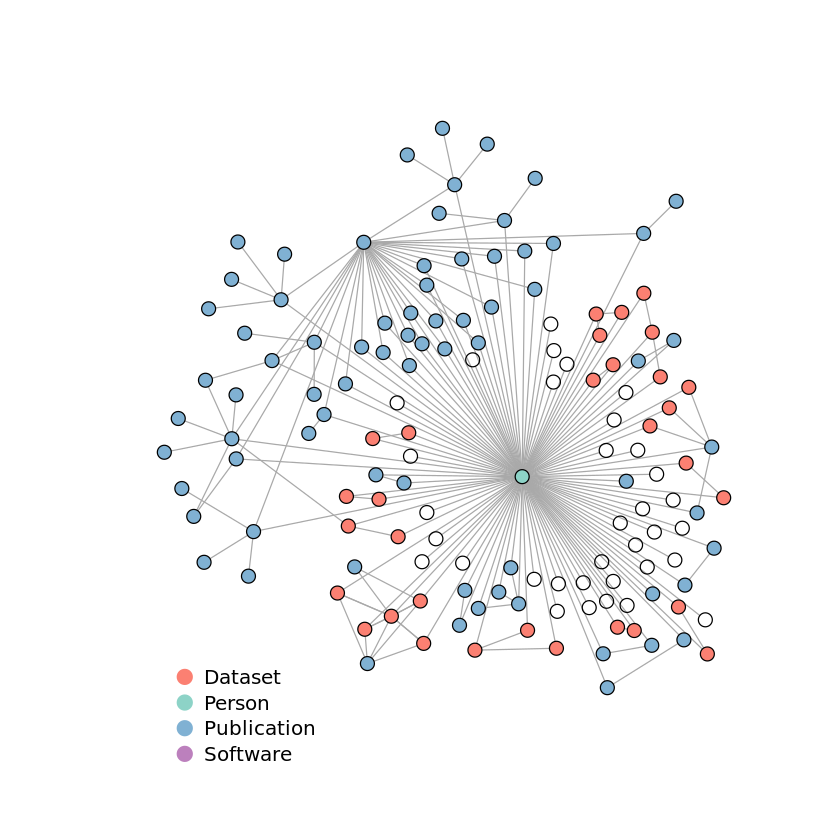

In [34]:
# generate data frame for nodes
people <- data.frame(id=data$data$person$id, pid_type=data$data$person$type)
publications <- data.frame(id=data$data$person$publications$nodes$id, pid_type=c('Publication'))
datasets <- data.frame(id=data$data$person$datasets$nodes$id, pid_type=data$data$person$datasets$nodes$type)
softwares <- data.frame(id=data$data$person$softwares$nodes$id, pid_type=data$data$person$softwares$nodes$type)
publication_references <- data.frame(id=bind_rows(data$data$person$publications$nodes$relatedIdentifiers)[,1], pid_type=c('Publication'))
dataset_references <- data.frame(id=bind_rows(data$data$person$datasets$nodes$relatedIdentifiers)[,1], pid_type=c('Publication'))
#software_references <- data.frame(id=bind_rows(data$data$person$softwares$nodes$relatedIdentifiers)[,1], pid_type=c('Publication'))
nodes <- unique(rbind(people, publications, datasets, softwares, publication_references, dataset_references))

publication_edges <- data.frame(to=publications[,1], from=data$data$person$id)
dataset_edges <- data.frame(to=datasets[,1], from=data$data$person$id)
software_edges <- data.frame(to=softwares[,1], from=data$data$person$id)
edges <- unique(rbind(publication_edges, dataset_edges, software_edges))
    
# loop through nodes, as they can have more than one edge
publications_with_references <- bind_rows(data$data$person$publications$nodes) %>% filter(lengths(relatedIdentifiers) != 0)
datasets_with_references <- bind_rows(data$data$person$datasets$nodes) %>% filter(lengths(relatedIdentifiers) != 0)
softwares_with_references <- bind_rows(data$data$person$softwares$nodes) %>% filter(lengths(relatedIdentifiers) != 0)

for (i in 1:nrow(publications_with_references)) {
  row <- data.frame(to=unlist(publications_with_references[i,3]), from=publications_with_references[i,1])
  edges <- unique(rbind(edges, row))
}

for (i in 1:nrow(datasets_with_references)) {
  row <- data.frame(to=unlist(datasets_with_references[i,3]), from=datasets_with_references[i,1])
  edges <- unique(rbind(edges, row))
}

#for (i in 1:nrow(softwareSourceCodes_with_references)) {
#  row <- data.frame(to=unlist(softwareSourceCodes_with_references[i,3]), from=softwareSourceCodes_with_references[i,1])
#  edges <- unique(rbind(edges, row))
#}

# express DOIs as URLs
nodes <- nodes %>% mutate(id = ifelse(startsWith(as.character(id), '10.'), paste('https://doi.org/', id, sep=''), as.character(id)))
edges <- edges %>% mutate(to = ifelse(startsWith(as.character(to), '10.'), paste('https://doi.org/', to, sep=''), as.character(to)))

# remove duplicates
nodes <- nodes %>% distinct(id, .keep_all = TRUE)

g <- graph_from_data_frame(d=unique(edges), vertices=unique(nodes))

# add node colors
cols <- brewer.pal(12, "Set3")
V(g)[(V(g)$pid_type=="Publication")]$color<-cols[5]
V(g)[(V(g)$pid_type=="Person")]$color<-cols[1]
V(g)[(V(g)$pid_type=="Dataset")]$color<-cols[4]
V(g)[(V(g)$pid_type=="Softwares")]$color<-cols[10]

# add labels to selected nodes
V(g)$label=NA

V(g)$size <- 5
E(g)$arrow.mode <- 0
l <- layout_with_dh(g)
plot(g, layout=l, arrow.mode=0)

# Add a legend
# pid_type is sorted alphabetically: 'Dataset' 'Person' 'Publication' 'SoftwareSourceCode'
legend("bottomleft", legend=levels(as.factor(V(g)$pid_type)), col = cols[c(4,1,5,10)], bty = "n", pch=20 , pt.cex = 2.5, cex = 1, horiz = FALSE, inset = c(0.1, -0.1))

In [35]:
# Generate a list of formatted citations in APA format for the publications, datasets and software

ids <- substring(publications[,1], 17)
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Publications')
display_markdown(content(response, as = 'text'))

ids <- substring(datasets[,1], 17)
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Datasets')
display_markdown(content(response, as = 'text'))

ids <- substring(softwareSourceCodes[,1], 17)
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Software')
display_markdown(content(response, as = 'text'))

## Publications

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). D2.2 Kickoff report. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.107019

ODIN Consortium, Thorisson, G., &amp; Fenner, M. (2013). D2.1 Kick off preparation, Communication plan and Website. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.154691

Fenner, M. (2013). Metrics and Attribution. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.706340

ODIN Consortium, Fenner, M., Thorisson, G., Ruiz, S., &amp; Brase, J. (2013). D4.1 Conceptual model of interoperability. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.824314

Friesike, S., &amp; Fenner, M. (2014). <i>Schreiben</i>. https://doi.org/10.2314/COSCV1.4

Heller, L., Blümel, I., Dietze, S., Fenner, M., Friesike, S., Hauschke, C., Heise, C., Jäschke, R., Kleinwechter, U., König, M., Mehlberg, M., Neumann, J., Pampel, H., &amp; Tullney, M. (2014). CoScience - Gemeinsam forschen und publizieren mit dem Netz. <i>Technische Informationsbibliothek (TIB), Hannover</i>. https://doi.org/10.2314/COSCV1

Zahedi, Z., Fenner, M., &amp; Costas, R. (2014). How consistent are altmetrics providers? Study of 1000 PLOS ONE publications using the PLOS ALM, Mendeley and Altmetric.com APIs. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.1041821

PLOS ALM, Fenner, M., &amp; Lin, J. (2014). An analysis of Wikipedia references across PLOS publications. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.1048991

Arning, U., Bargheer, M., Blümel, I., Dietze, S., Fenner, M., Friesike, S., Hauschke, C., Heise, C., Heller, L., Hohmann, T., Jäschke, R., Kleinwechter, U., Leiß, C., Lemke, D., König, M., Mehlberg, M., Neumann, J., Pampel, H., Peters, I., … Tullney, M. (2015). CoScience - Gemeinsam forschen und publizieren mit dem Netz. <i>Technische Informationsbibliothek (TIB), Hannover</i>. https://doi.org/10.2314/COSCV2

Friesike, S., &amp; Fenner, M. (2015). <i>Schreiben</i>. https://doi.org/10.2314/COSCV2.4

ODIN Consortium, Thorisson, G., &amp; Fenner, M. (2013). D2.1 Kick off preparation, Communication plan and Website. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.154691.V1

Fenner, M. (2013). Metrics and Attribution. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.706340.V1

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). D2.2 Kickoff report. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.107019.V4

ODIN Consortium, Fenner, M., Thorisson, G., Ruiz, S., &amp; Brase, J. (2013). D4.1 Conceptual model of interoperability. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.824314.V1

PLOS ALM, Fenner, M., &amp; Lin, J. (2014). An analysis of Wikipedia references across PLOS publications. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.1048991.V1

PLOS ALM, Fenner, M., &amp; Lin, J. (2014). An analysis of Wikipedia references across PLOS publications. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.1048991.V2

PLOS ALM, Fenner, M., &amp; Lin, J. (2014). An analysis of Wikipedia references across PLOS publications. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.1048991.V3

Fenner, M., &amp; Demeranville, T. (2016). Project Identifiers. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.4216323

Fenner, M., &amp; Demeranville, T. (2016). Project Identifiers. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.4216323.V2

Fenner, M. (2015, August 17). <i>From Pilot to Service</i>. https://doi.org/10.5438/S8GF-0CK9

Fenner, M. (2016). <i>Eating your own Dog Food</i>. https://doi.org/10.5438/4K3M-NYVG

Fenner, M. (2016, November 3). <i>A common API for retrieving DataCite Metadata</i>. https://doi.org/10.5438/6WCF-EFW5

Fenner, M. (2015, August 15). <i>Reference Lists and Tables of Content</i>. https://doi.org/10.5438/5AEG-WEEV

Fenner, M. (2015). <i>Software Citation Workflows</i>. https://doi.org/10.5438/1H7N-3CEN

Fenner, M. (2015, October 26). <i>Auto-Update Has Arrived!</i> https://doi.org/10.5438/FERW-CWHQ

Fenner, M., &amp; Garza, K. (2016). <i>Announcing Our New Application Developer</i>. https://doi.org/10.5438/Y131-YX9D

Fenner, M. (2015, September 16). <i>Adding References to the DataCite Blog</i>. https://doi.org/10.5438/2WFX-2HZ1

Fenner, M. (2016). <i>Cool DOI's</i>. https://doi.org/10.5438/55E5-T5C0

Fenner, M. (2015, September 22). <i>Persistent Identifiers: Enabling Services for Data Intensive Research</i>. https://doi.org/10.5438/JM9F-325F

Fenner, M. (2015, December 23). <i>Infrastructure Tips for the Non-Profit Startup</i>. https://doi.org/10.5438/T0AP-D5W7

Fenner, M. (2015, October 2). <i>Discussing the Scholarly Container</i>. https://doi.org/10.5438/D9EQ-9DGA

Fenner, M. (2015, December 28). <i>Announcing the DataCite Blog Relaunch</i>. https://doi.org/10.5438/XCBJ-G7ZY

Fenner, M. (2015). <i>Overcoming Development Pain</i>. https://doi.org/10.5438/8QKH-1R6~

Fenner, M. (2015, November 9). <i>Announcing the DataCite Profiles Service</i>. https://doi.org/10.5438/15X1-BJ6R

Fenner, M. (2016, May 4). <i>Thinking about CSV</i>. https://doi.org/10.5438/4QX3-RP8Y

Fenner, M. (2015, September 3). <i>Using YAML Frontmatter with CSV</i>. https://doi.org/10.5438/5HZJ-5KDS

Fenner, M. (2016, April 14). <i>It's all about Relations</i>. https://doi.org/10.5438/PE54-ZJ5T

Fenner, M. (2015, October 1). <i>Thoughts on the Research Data Alliance 6th Plenary</i>. https://doi.org/10.5438/7RXD-S8A3

Fenner, M. (2016, May 13). <i>Data catalog cards: simplifying article/data linking</i>. https://doi.org/10.5438/CAB5-TEG0

Fenner, M. (2015, September 9). <i>Announcing Data-Level Metrics in DataCite Labs</i>. https://doi.org/10.5438/JZG5-VCQV

Fenner, M. (2016, November 1). <i>Announcing the Organization Identifier Project: a Way Forward</i>. https://doi.org/10.5438/TNHX-54CG

Fenner, M. (2016, July 18). <i>Dynamic Data Citation Webinar</i>. https://doi.org/10.5438/Y4KS-KSBC

Fenner, M. (2015, October 16). <i>Happy Birthday ORCID</i>. https://doi.org/10.5438/C61Q-Z2K7

Fenner, M. (2015, August 20). <i>Digging into Metadata using R</i>. https://doi.org/10.5438/1HV8-2GC2

Fenner, M. (2015, October 29). <i>Explaining the DataCite/ORCID Auto-update</i>. https://doi.org/10.5438/3DFW-Z4KQ

Fenner, M. (2016, January 11). <i>Launching the DataCite Status Page</i>. https://doi.org/10.5438/YHCJ-P5HR

Fenner, M. (2015, September 18). <i>Differences between ORCID and DataCite Metadata</i>. https://doi.org/10.5438/BC11-CQW1

Fenner, M. (2016, March 30). <i>DataCite is Hiring an Application Developer</i>. https://doi.org/10.5438/MSK0-15R2

Fenner, M. (2016, July 5). <i>Relaunching DataCite Search</i>. https://doi.org/10.5438/VQ2T-VR4K

Fenner, M. (2015). Contributor Information in DataCite Metadata. <i>DataCite Blog</i>. https://doi.org/10.5438/W029-Y6W~

## Datasets

Fenner, M., &amp; Adie, E. (2012). <i>CrowdoMeter Tweet Classifications</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.90829

Fenner, M., &amp; Adie, E. (2012). <i>CrowdoMeter Tweets</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.90828

Fenner, M., &amp; Lin, J. (2013). <i>Article-Level Metrics f</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.681735

Fenner, M., &amp; Lin, J. (2013). <i>Article-Level Metrics Hannover Medical School</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.681737

Fenner, M., &amp; Lin, J. (2013). <i>Cumulative usage statistics for PLOS papers from PLOS website</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.816962

Fenner, M., &amp; Lin, J. (2013). <i>Cumulative usage statistics for PLOS papers from PubMed Central</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.816961

Fenner, M., Alperin, J. P., &amp; Zahedi, Z. (2013). <i>5000 random journal article CrossRef DOIs from 2011</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.821209

Fenner, M., &amp; Zahedi, Z. (2013). <i>5000 random journal article CrossRef DOIs from 2012</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.821213

Zahedi, Z., Fenner, M., &amp; Costas, R. (2014). <i>1000 random PLOS ONE DOIs from 2013</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.1066168

Fenner, M., &amp; Adie, E. (2012). <i>CrowdoMeter Tweets</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.90828.V1

Fenner, M., &amp; Adie, E. (2012). <i>CrowdoMeter Tweet Classifications</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.90829.V1

Fenner, M., &amp; Lin, J. (2013). <i>Article-Level Metrics f</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.681735.V1

Fenner, M., &amp; Lin, J. (2013). <i>Article-Level Metrics Hannover Medical School</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.681737.V1

Fenner, M., &amp; Lin, J. (2013). <i>Article-Level Metrics Hannover Medical School</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.681737.V2

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). <i>TEST Kickoff report</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.107019.V1

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). <i>D2.2 Kickoff report</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.107019.V2

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). <i>TEST do not use!!</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.107019.V3

Fenner, M., &amp; Lin, J. (2013). <i>Cumulative usage statistics for PLOS papers from PubMed Central</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.816961.V1

Fenner, M., &amp; Lin, J. (2013). <i>Cumulative usage statistics for PLOS website</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.816962.V1

Fenner, M., &amp; Lin, J. (2013). <i>Cumulative usage statistics for PLOS papers from PLOS website</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.816962.V2

Fenner, M., Alperin, J. P., &amp; Zahedi, Z. (2013). <i>5000 random journal article CrossRef DOIs from 2011</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.821209.V1

Fenner, M., &amp; Zahedi, Z. (2013). <i>5000 random journal article CrossRef DOIs from 2012</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.821213.V1

Zahedi, Z., Fenner, M., &amp; Costas, R. (2014). <i>1000 random PLOS ONE DOIs from 2013</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.1066168.V1

Zahedi, Z., Fenner, M., &amp; Costas, R. (2014). <i>1000 random PLOS ONE DOIs from 2013</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.1066168.V2

Demeranville, T., Brown, J., Fenner, M., Cruse, P., Haak, L., Paglione, L., Bilder, G., Lin, J., &amp; Pentz, E. (2016). <i>Organisation Identifiers - Minimum viable product requirements</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.3479141

Demeranville, T., Brown, J., Fenner, M., Cruse, P., Haak, L., Paglione, L., Bilder, G., Lin, J., &amp; Pentz, E. (2016). <i>Organisation Identifiers - Minimum viable product requirements</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.3479141.V1

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., Bernal Llinares, M., &amp; Clark, T. (2018). <i>Listing Of Data Repositories That Embed Schema.Org Metadata In Dataset Landing Pages</i> [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1202174

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., Bernal Llinares, M., Schindler, U., &amp; Clark, T. (2018). <i>Listing of data repositories that embed schema.org metadata in dataset landing pages</i> (Version 1.1.2) [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1202173

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., Bernal Llinares, M., Schindler, U., &amp; Clark, T. (2018). <i>Listing Of Data Repositories That Embed Schema.Org Metadata In Dataset Landing Pages</i> [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1202178

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., Bernal Llinares, M., Schindler, U., &amp; Clark, T. (2018). <i>Listing Of Data Repositories That Embed Schema.Org Metadata In Dataset Landing Pages</i> [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1262598

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., Bernal Llinares, M., Schindler, U., &amp; Clark, T. (2018). <i>Listing of data repositories that embed schema.org metadata in dataset landing pages</i> (Version 1.1.2) [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1263942

ERROR: Error in substring(softwareSourceCodes[, 1], 17): object 'softwareSourceCodes' not found


In [36]:
# Generate a list of formatted citations in APA format for the references (if they are DataCite DOIs)

ids <- publication_references[,1]
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Publication References')
display_markdown(content(response, as = 'text'))

ids <- dataset_references[,1]
ids <- paste(ids, collapse = ',')
url <- paste('https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=', ids, sep = '')
response <- GET(url, accept("text/x-bibliography"))
display_markdown('## Dataset References')
display_markdown(content(response, as = 'text'))  

## Publication References

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). D2.2 Kickoff report. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.107019

ODIN Consortium, Thorisson, G., &amp; Fenner, M. (2013). D2.1 Kick off preparation, Communication plan and Website. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.154691

Fenner, M. (2013). Metrics and Attribution. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.706340

ODIN Consortium, Fenner, M., Thorisson, G., Ruiz, S., &amp; Brase, J. (2013). D4.1 Conceptual model of interoperability. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.824314

Heller, L., Blümel, I., Dietze, S., Fenner, M., Friesike, S., Hauschke, C., Heise, C., Jäschke, R., Kleinwechter, U., König, M., Mehlberg, M., Neumann, J., Pampel, H., &amp; Tullney, M. (2014). CoScience - Gemeinsam forschen und publizieren mit dem Netz. <i>Technische Informationsbibliothek (TIB), Hannover</i>. https://doi.org/10.2314/COSCV1

PLOS ALM, Fenner, M., &amp; Lin, J. (2014). An analysis of Wikipedia references across PLOS publications. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.1048991

DataCite Metadata Working Group. (2014). DataCite Metadata Schema for the Publication and Citation of Research Data v3.1. <i>DataCite E.V.</i> https://doi.org/10.5438/0010

Bilder, G., Lin, J., &amp; Neylon, C. (2015). Principles for Open Scholarly Infrastructures-v1. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.1314859

Arning, U., Bargheer, M., Blümel, I., Dietze, S., Fenner, M., Friesike, S., Hauschke, C., Heise, C., Heller, L., Hohmann, T., Jäschke, R., Kleinwechter, U., Leiß, C., Lemke, D., König, M., Mehlberg, M., Neumann, J., Pampel, H., Peters, I., … Tullney, M. (2015). CoScience - Gemeinsam forschen und publizieren mit dem Netz. <i>Technische Informationsbibliothek (TIB), Hannover</i>. https://doi.org/10.2314/COSCV2

Fenner, M., Demeranville, T., Kotarski, R., Vision, T., Rueda, L., Dasler, R., Haak, L., &amp; Cruse, P. (2015). <i>D2.1: Artefact, Contributor, And Organisation Relationship Data Schema</i>. Zenodo. https://doi.org/10.5281/ZENODO.30799

Mayo, C., Hull, E. A., &amp; Vision, T. J. (2015). The Location Of The Citation: Changing Practices In How Publications Cite Original Data In The Dryad Digital Repository. <i>Zenodo</i>. https://doi.org/10.5281/ZENODO.32412

Fenner, M., Wass, J., Song, J., Dennis, Z., Whitwell, M., Osowski, J., Ivimey-Cook, R., Cave, R., Lin, J., &amp; Chodacki, J. (2016). <i>Lagotto 5.0.1</i> (Version v.5.0.1) [Computer software]. Zenodo. https://doi.org/10.5281/ZENODO.49516

Demeranville, T., Brown, J., Fenner, M., Cruse, P., Haak, L., Paglione, L., Bilder, G., Lin, J., &amp; Pentz, E. (2016). <i>Organisation Identifiers - Minimum viable product requirements</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.3479141

DataCite Metadata Working Group. (2016). DataCite Metadata Schema Documentation for the Publication and Citation of Research Data v4.0. <i>DataCite E.V.</i> https://doi.org/10.5438/0012

Bilder, G., Brown, J., &amp; Demeranville, T. (2016). <i>Organisation identifiers: current provider survey</i>. ORCID. https://doi.org/10.5438/4716

Fenner, M., Paglione, L., Demeranville, T., &amp; Bilder, G. (2016). <i>Technical Considerations for an Organization Identifier Registry</i>. ORCID. https://doi.org/10.5438/7885

Cruse, P., Haak, L., &amp; Pentz, E. (2016). <i>Organization Identifier Project: A Way Forward</i>. ORCID. https://doi.org/10.5438/2906

Fenner, M., &amp; Demeranville, T. (2016). Project Identifiers. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.4216323

Fenner, M. (2016). <i>Cool DOI's</i>. https://doi.org/10.5438/55E5-T5C0

Cruse, P., Rueda, L., Garza, K., &amp; Fenner, M. (2015). <i>DataCite Blog</i> (Version 1.0). DataCite. https://doi.org/10.5438/0000-00SS

Klein, M., Van de Sompel, H., Sanderson, R., Shankar, H., Balakireva, L., Zhou, K., &amp; Tobin, R. (2014). Scholarly Context Not Found: One in Five Articles Suffers from Reference Rot. <i>PLoS ONE</i>, <i>9</i>(12), e115253. https://doi.org/10.1371/JOURNAL.PONE.0115253

McEntyre, J., Sarkans, U., &amp; Brazma, A. (2015). The BioStudies database. <i>Molecular Systems Biology</i>, <i>11</i>(12), 847–847. https://doi.org/10.15252/MSB.20156658

Garza, K., Goble, C., Brooke, J., &amp; Jay, C. (2015). Framing the community data system interface. <i>Association for Computing Machinery (ACM)</i>. https://doi.org/10.1145/2783446.2783605

Transitive Credit as a Means to Address Social and Technological Concerns Stemming from Citation and Attribution of Digital Products. (2014). <i>Journal of Open Research Software</i>, <i>2</i>(1), e20. https://doi.org/10.5334/JORS.BE

## Dataset References

Fenner, M., &amp; Adie, E. (2012). <i>CrowdoMeter Tweet Classifications</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.90829

Fenner, M., &amp; Adie, E. (2012). <i>CrowdoMeter Tweets</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.90828

ODIN Consortium, Fenner, M., &amp; Thorisson, G. (2013). D2.2 Kickoff report. <i>Figshare</i>. https://doi.org/10.6084/M9.FIGSHARE.107019

Fenner, M., &amp; Lin, J. (2013). <i>Article-Level Metrics f</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.681735

Fenner, M., &amp; Lin, J. (2013). <i>Article-Level Metrics Hannover Medical School</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.681737

Fenner, M., &amp; Lin, J. (2013). <i>Cumulative usage statistics for PLOS papers from PLOS website</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.816962

Fenner, M., &amp; Lin, J. (2013). <i>Cumulative usage statistics for PLOS papers from PubMed Central</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.816961

Fenner, M., Alperin, J. P., &amp; Zahedi, Z. (2013). <i>5000 random journal article CrossRef DOIs from 2011</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.821209

Fenner, M., &amp; Zahedi, Z. (2013). <i>5000 random journal article CrossRef DOIs from 2012</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.821213

Zahedi, Z., Fenner, M., &amp; Costas, R. (2014). <i>1000 random PLOS ONE DOIs from 2013</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.1066168

Demeranville, T., Brown, J., Fenner, M., Cruse, P., Haak, L., Paglione, L., Bilder, G., Lin, J., &amp; Pentz, E. (2016). <i>Organisation Identifiers - Minimum viable product requirements</i> [Data set]. figshare. https://doi.org/10.6084/M9.FIGSHARE.3479141

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., Bernal Llinares, M., &amp; Clark, T. (2018). <i>Listing Of Data Repositories That Embed Schema.Org Metadata In Dataset Landing Pages</i> [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1202174

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., Bernal Llinares, M., Schindler, U., &amp; Clark, T. (2018). <i>Listing of data repositories that embed schema.org metadata in dataset landing pages</i> (Version 1.1.2) [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1202173

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., Bernal Llinares, M., Schindler, U., &amp; Clark, T. (2018). <i>Listing Of Data Repositories That Embed Schema.Org Metadata In Dataset Landing Pages</i> [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1202178

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., Bernal Llinares, M., Schindler, U., &amp; Clark, T. (2018). <i>Listing Of Data Repositories That Embed Schema.Org Metadata In Dataset Landing Pages</i> [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1262598

Fenner, M., Crosas, M., Durand, G., Wimalaratne, S., Gräf, F., Hallett, R., Bernal Llinares, M., Schindler, U., &amp; Clark, T. (2018). <i>Listing of data repositories that embed schema.org metadata in dataset landing pages</i> (Version 1.1.2) [Data set]. Zenodo. https://doi.org/10.5281/ZENODO.1263942

Fenner, M., Crosas, M., Grethe, J., Kennedy, D., Hermjakob, H., Rocca-Serra, P., Durand, G., Berjon, R., Karcher, S., Martone, M., &amp; Clark, T. (2017). A Data Citation Roadmap for Scholarly Data Repositories. <i>BioRxiv</i>. https://doi.org/10.1101/097196

Fenner, M., Crosas, M., Grethe, J. S., Kennedy, D., Hermjakob, H., Rocca-Serra, P., Durand, G., Berjon, R., Karcher, S., Martone, M., &amp; Clark, T. (2019). A data citation roadmap for scholarly data repositories. <i>Scientific Data</i>, <i>6</i>(1). https://doi.org/10.1038/S41597-019-0031-8